### Import libraries

In [1]:
# import statements
%load_ext autoreload
%autoreload 2
%cd "../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


### Generate data

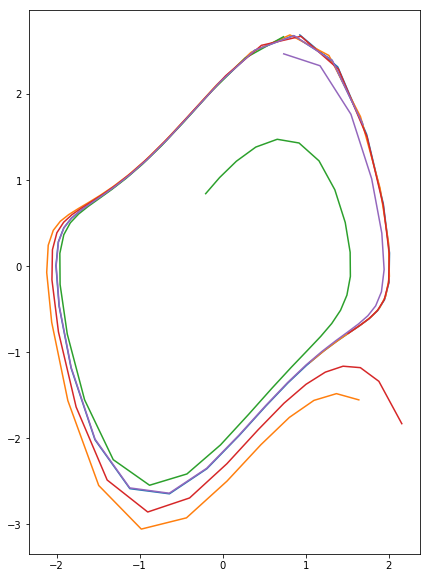

In [2]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], (1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
t = torch.linspace(0., 7., 40)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1
    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')

## Implementation-1, gradients computed via sensitivities (uses autograd as a subroutine) 

### Initialize the model, parameters, variables, etc

In [ ]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
Linv = torch.cholesky(K(Zt,Zt)).inverse()
U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        N = x0.shape[0]  # problem dimensionality
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
                x = xS[:,:,0].view(-1,D) # N,D
                S = xS[:,:,1:] # N,D,MD
                th = list(func.parameters())[0]
                dxs = []
                dSs = []
                for j in range(N):
                    x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
                    S_ = S[j] # D,MD
                    J = [] # accumulate columns of J here
                    R = [] # accumulate columns of R here
                    for i in range(D): # partial derivative of output dimension i 
                        with torch.set_grad_enabled(True):
                            f = func(t,x_)[0,i]
                            dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
                            J.append(dfdxth[0])
                            R.append(dfdxth[1].view(1,-1)) # 1,MD
                    J = torch.cat(J) # D,D
                    R = torch.cat(R) # D,MD
                    dS = torch.matmul(J,S_)+R # D,MD
                    dx = func(t,x_) # 1,D
                    dxs.append(dx.unsqueeze(2)) # 1,D,1
                    dSs.append(dS.unsqueeze(0)) # 1,D,MD
                dx = torch.cat(dxs) # N,D,1
                dS = torch.cat(dSs) # N,D,MD
                dxdS = torch.cat([dx,dS],2)
                return dxdS
            x0 = torch.unsqueeze(x0,2) # N,D,1
            S0 = torch.zeros(N,D,MD)
            xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
            xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
            # print(grad_output[0].shape) # N,T,D
            dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    

### Optimize

In [ ]:
# optimization

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)

    
for itr in range(500):
    optimizer.zero_grad()
    T   = min(3+itr//10, len(t))
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint_forw_sens(kreg,x0,t_)
    loss = torch.sum((Yt_-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt_)*torch.sum(logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),kreg.U)))/2
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


### Visualize

In [ ]:
# plotting
xode = odeint_forw_sens(kreg, x0, t).detach().numpy()
U = kreg.U.detach().numpy()
Z = Zt.detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Implementation-2 that uses Torch autograd, no sensitivities/adjoints 

### Initialize the model, parameters, variables, etc

In [ ]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

npode = KernelRegression()
# lbfgs = optim.LBFGS(npode.parameters(), lr=1e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)
optimizer = optim.SGD(npode.parameters(), lr=1e-5)


### Optimize

In [ ]:
# optimization
# def closure():
#     optimizer.zero_grad()
#     xode = odeint(npode, x0, t).permute([1,0,2])
#     loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
#     loss.backward()
#     return loss
    
for itr in range(1000):
    optimizer.zero_grad()
    xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D + \
        torch.sum(torch.diag(torch.mm(npode.U.t(),npode.U)))/2
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
            loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

### Visualize

In [ ]:
# plotting
xode = odeint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Old stuff

In [ ]:
# working
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
# F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
# F_ = F_.contiguous().view(-1,D)
# Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
# Kxz = K(Zt,Z_)
# Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
# U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
# Linv = torch.cholesky(K(Zt,Zt)).inverse()
# U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS):
                x = xS[0:D].view(-1,D).detach().requires_grad_(True)
                S = xS[D:].view(D,MD)
                th = list(func.parameters())[0]
                J = [] # accumulate columns of J here
                R = [] # accumulate columns of R here
                for i in range(D): # partial derivative of output dimension i 
                    with torch.set_grad_enabled(True):
                        f = func(t,x)[0,i]
                        dfdxth = torch.autograd.grad(f, [x,th], allow_unused=False, retain_graph=False)
                        J.append(dfdxth[0])
                        R.append(dfdxth[1])
                J = torch.cat(J)  # D,D
                R = torch.cat([r.view(1,-1) for r in R]) # D,MD
                dS = torch.matmul(J,S)+R
                dx = func(t,x)[0]
                dxdS = torch.cat((dx.view(-1),dS.view(-1)))
                return dxdS
            S0 = torch.zeros(D,MD)
            xS0 = torch.cat((x0.view(-1),S0.view(-1)),0)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,1,(D+DMD)
            xode2 = xS[:,0:2].unsqueeze(0) # 1,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,2:].t().view(D,MD,-1).permute([0,2,1]) # D,T,MD
            dlossdx = grad_output[0][0].t().unsqueeze(2) # D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    
logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)
    
for itr in range(500):
    optimizer.zero_grad()
    xode = odeint_forw_sens(kreg,x0,t)
    loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


## Inference using MCMC

### Initialize Model and params

In [3]:
# # create variables, functions etc
# M   = 6 # MxM inducing grid
# D   = 2
# sf  = 1
# ell = 0.75

# torch.set_default_tensor_type(torch.DoubleTensor)
# xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
# yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
# xv,yv = np.meshgrid(xv,yv)
# Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
# Zt = torch.from_numpy(Z)
# Yt = torch.from_numpy(Y)
# U0 = 0.1*torch.randn(M*M, D)
# # U0 = VDP().forward(0,Zt)

# def _flatten(sequence):
#     flat = [p.contiguous().view(-1) for p in sequence]
#     return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

# def sq_dist(X1,X2):
#     X1 = X1 / ell
#     X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
#     X2 = X2 / ell
#     X2s = torch.sum(X2**2, dim=1).view([1,-1])
#     return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

# def K(X1,X2):
#     dist = sq_dist(X1,X2)
#     return sf**2 * torch.exp(-dist / 2)

# # gradient matching
# F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
# F_ = F_.contiguous().view(-1,D)
# Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
# Kxz = K(Zt,Z_)
# Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
# U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
# Linv = torch.cholesky(K(Zt,Zt)).inverse()
# U0 = torch.mm(Linv,U0) # whitened

# class KernelRegression(torch.nn.Module):
#     def __init__(self):
#         super(KernelRegression, self).__init__()
#         self.U = torch.nn.Parameter(U0, requires_grad=True)
#         self.Z = Zt
#         self.Kzz = K(Zt,Zt)
#         self.Kzzinv = self.Kzz.inverse()
#         self.L = torch.cholesky(self.Kzz)
#         self.KzzinvL = torch.mm(self.Kzzinv,self.L)

#     def forward(self, t, X):
#         T = torch.mm(K(X,self.Z),self.KzzinvL)
#         return torch.mm(T,self.U)

# class ODEINT_FS(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, func, x0, t, th):
#         xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
#         ctx.func = func
#         ctx.save_for_backward(x0,t,th,xode)
#         return xode # N,T,D
#     @staticmethod
#     def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
#         # print('backward')
#         func = ctx.func
#         x0,t,th,xode = ctx.saved_tensors
#         N = x0.shape[0]  # problem dimensionality
#         D = x0.shape[1]  # problem dimensionality
#         MD = torch.numel(th) # number of parameters in the differential function
#         with torch.no_grad():
#             def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
#                 x = xS[:,:,0].view(-1,D) # N,D
#                 S = xS[:,:,1:] # N,D,MD
#                 th = list(func.parameters())[0]
#                 dxs = []
#                 dSs = []
#                 for j in range(N):
#                     x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
#                     S_ = S[j] # D,MD
#                     J = [] # accumulate columns of J here
#                     R = [] # accumulate columns of R here
#                     for i in range(D): # partial derivative of output dimension i 
#                         with torch.set_grad_enabled(True):
#                             f = func(t,x_)[0,i]
#                             dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
#                             J.append(dfdxth[0])
#                             R.append(dfdxth[1].view(1,-1)) # 1,MD
#                     J = torch.cat(J) # D,D
#                     R = torch.cat(R) # D,MD
#                     dS = torch.matmul(J,S_)+R # D,MD
#                     dx = func(t,x_) # 1,D
#                     dxs.append(dx.unsqueeze(2)) # 1,D,1
#                     dSs.append(dS.unsqueeze(0)) # 1,D,MD
#                 dx = torch.cat(dxs) # N,D,1
#                 dS = torch.cat(dSs) # N,D,MD
#                 dxdS = torch.cat([dx,dS],2)
#                 return dxdS
#             x0 = torch.unsqueeze(x0,2) # N,D,1
#             S0 = torch.zeros(N,D,MD)
#             xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
#             xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
#             xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
#             # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
#             S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
#             # print(grad_output[0].shape) # N,T,D
#             dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
#             dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
#         return None,None,None,dlossdU # N,T,D
    
# odeint_fs = ODEINT_FS.apply
# kreg = KernelRegression()

# # check why doesn't work
# # from torch.autograd import gradcheck
# # th_ = _flatten(kreg.parameters())
# # test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# # print(test)

# def odeint_forw_sens(func, x0, t):
#     th = _flatten(func.parameters())
#     xode = odeint_fs(kreg, x0, t, th)
#     return xode
    
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

kreg = KernelRegression()
Kzzinv = K(Zt, Zt).inverse()
# lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)

### Inference

In [11]:
from samplers import MALA, SGLD

def closure():
    xode = odeint(kreg, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(kreg.logsn)**2) +  torch.numel(Xt)*torch.sum(kreg.logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    return loss

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
# params = kreg.parameters()
params = [kreg.U]
# sampler = MALA(params, lr=0.0001, add_noise=False)
# sampler = MALA(params, lr=1e-5, add_noise=True)
sampler = SGLD(params, lr0=0.0001, gamma=0.55, t0=100, alpha=1.)


chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=1000)

[Parameter containing:
tensor([[ 0.2831, -0.0731],
        [-0.5090,  1.7030],
        [-0.7187,  2.1088],
        [ 0.9562,  1.3373],
        [ 0.8863,  0.0571],
        [ 0.5437, -1.4617],
        [-0.7474,  0.5710],
        [-1.2210,  2.4149],
        [-2.1473,  1.8292],
        [ 0.1129,  1.1250],
        [ 2.3033, -0.1211],
        [ 1.1728, -0.7208],
        [-0.0154,  1.8024],
        [-1.2006,  0.3181],
        [-0.1344,  0.6994],
        [-0.3011,  1.1065],
        [ 1.7793,  0.8770],
        [ 1.3318,  0.4900],
        [ 0.1347,  0.7735],
        [-1.9928, -1.3334],
        [ 0.2899, -0.5697],
        [ 0.0992, -1.2589],
        [ 1.5739,  0.9068],
        [ 1.1945,  0.2358],
        [ 0.8983,  1.0819],
        [-1.5109, -0.0308],
        [-1.0157, -0.8651],
        [ 0.7416, -2.4617],
        [ 2.3708, -2.8506],
        [ 1.4929, -2.5391],
        [ 0.4421,  0.7537],
        [-0.9360,  1.2377],
        [-0.4357, -0.4985],
        [ 0.5004, -2.6070],
        [-0.3223, -2.4240

Burn-in iter 422
Burn-in iter 423
Burn-in iter 424
Burn-in iter 425
Burn-in iter 426
Burn-in iter 427
Burn-in iter 428
Burn-in iter 429
Burn-in iter 430
Burn-in iter 431
Burn-in iter 432
Burn-in iter 433
Burn-in iter 434
Burn-in iter 435
Burn-in iter 436
Burn-in iter 437
Burn-in iter 438
Burn-in iter 439
Burn-in iter 440
Burn-in iter 441
Burn-in iter 442
Burn-in iter 443
Burn-in iter 444
Burn-in iter 445
Burn-in iter 446
Burn-in iter 447
Burn-in iter 448
Burn-in iter 449
Burn-in iter 450
Burn-in iter 451
Burn-in iter 452
Burn-in iter 453
Burn-in iter 454
Burn-in iter 455
Burn-in iter 456
Burn-in iter 457
Burn-in iter 458
Burn-in iter 459
Burn-in iter 460
Burn-in iter 461
Burn-in iter 462
Burn-in iter 463
Burn-in iter 464
Burn-in iter 465
Burn-in iter 466
Burn-in iter 467
Burn-in iter 468
Burn-in iter 469
Burn-in iter 470
Burn-in iter 471
Burn-in iter 472
Burn-in iter 473
Burn-in iter 474
Burn-in iter 475
Burn-in iter 476
Burn-in iter 477
Burn-in iter 478
Burn-in iter 479
Burn-in iter 4

Burn-in iter 904
Burn-in iter 905
Burn-in iter 906
Burn-in iter 907
Burn-in iter 908
Burn-in iter 909
Burn-in iter 910
Burn-in iter 911
Burn-in iter 912
Burn-in iter 913
Burn-in iter 914
Burn-in iter 915
Burn-in iter 916
Burn-in iter 917
Burn-in iter 918
Burn-in iter 919
Burn-in iter 920
Burn-in iter 921
Burn-in iter 922
Burn-in iter 923
Burn-in iter 924
Burn-in iter 925
Burn-in iter 926
Burn-in iter 927
Burn-in iter 928
Burn-in iter 929
Burn-in iter 930
Burn-in iter 931
Burn-in iter 932
Burn-in iter 933
Burn-in iter 934
Burn-in iter 935
Burn-in iter 936
Burn-in iter 937
Burn-in iter 938
Burn-in iter 939
Burn-in iter 940
Burn-in iter 941
Burn-in iter 942
Burn-in iter 943
Burn-in iter 944
Burn-in iter 945
Burn-in iter 946
Burn-in iter 947
Burn-in iter 948
Burn-in iter 949
Burn-in iter 950
Burn-in iter 951
Burn-in iter 952
Burn-in iter 953
Burn-in iter 954
Burn-in iter 955
Burn-in iter 956
Burn-in iter 957
Burn-in iter 958
Burn-in iter 959
Burn-in iter 960
Burn-in iter 961
Burn-in iter 9

Burn-in iter 1365
Burn-in iter 1366
Burn-in iter 1367
Burn-in iter 1368
Burn-in iter 1369
Burn-in iter 1370
Burn-in iter 1371
Burn-in iter 1372
Burn-in iter 1373
Burn-in iter 1374
Burn-in iter 1375
Burn-in iter 1376
Burn-in iter 1377
Burn-in iter 1378
Burn-in iter 1379
Burn-in iter 1380
Burn-in iter 1381
Burn-in iter 1382
Burn-in iter 1383
Burn-in iter 1384
Burn-in iter 1385
Burn-in iter 1386
Burn-in iter 1387
Burn-in iter 1388
Burn-in iter 1389
Burn-in iter 1390
Burn-in iter 1391
Burn-in iter 1392
Burn-in iter 1393
Burn-in iter 1394
Burn-in iter 1395
Burn-in iter 1396
Burn-in iter 1397
Burn-in iter 1398
Burn-in iter 1399
Burn-in iter 1400
Burn-in iter 1401
Burn-in iter 1402
Burn-in iter 1403
Burn-in iter 1404
Burn-in iter 1405
Burn-in iter 1406
Burn-in iter 1407
Burn-in iter 1408
Burn-in iter 1409
Burn-in iter 1410
Burn-in iter 1411
Burn-in iter 1412
Burn-in iter 1413
Burn-in iter 1414
Burn-in iter 1415
Burn-in iter 1416
Burn-in iter 1417
Burn-in iter 1418
Burn-in iter 1419
Burn-in it

Burn-in iter 1823
Burn-in iter 1824
Burn-in iter 1825
Burn-in iter 1826
Burn-in iter 1827
Burn-in iter 1828
Burn-in iter 1829
Burn-in iter 1830
Burn-in iter 1831
Burn-in iter 1832
Burn-in iter 1833
Burn-in iter 1834
Burn-in iter 1835
Burn-in iter 1836
Burn-in iter 1837
Burn-in iter 1838
Burn-in iter 1839
Burn-in iter 1840
Burn-in iter 1841
Burn-in iter 1842
Burn-in iter 1843
Burn-in iter 1844
Burn-in iter 1845
Burn-in iter 1846
Burn-in iter 1847
Burn-in iter 1848
Burn-in iter 1849
Burn-in iter 1850
Burn-in iter 1851
Burn-in iter 1852
Burn-in iter 1853
Burn-in iter 1854
Burn-in iter 1855
Burn-in iter 1856
Burn-in iter 1857
Burn-in iter 1858
Burn-in iter 1859
Burn-in iter 1860
Burn-in iter 1861
Burn-in iter 1862
Burn-in iter 1863
Burn-in iter 1864
Burn-in iter 1865
Burn-in iter 1866
Burn-in iter 1867
Burn-in iter 1868
Burn-in iter 1869
Burn-in iter 1870
Burn-in iter 1871
Burn-in iter 1872
Burn-in iter 1873
Burn-in iter 1874
Burn-in iter 1875
Burn-in iter 1876
Burn-in iter 1877
Burn-in it

Sample iter: 301
Sample iter: 302
Sample iter: 303
Sample iter: 304
Sample iter: 305
Sample iter: 306
Sample iter: 307
Sample iter: 308
Sample iter: 309
Sample iter: 310
Sample iter: 311
Sample iter: 312
Sample iter: 313
Sample iter: 314
Sample iter: 315
Sample iter: 316
Sample iter: 317
Sample iter: 318
Sample iter: 319
Sample iter: 320
Sample iter: 321
Sample iter: 322
Sample iter: 323
Sample iter: 324
Sample iter: 325
Sample iter: 326
Sample iter: 327
Sample iter: 328
Sample iter: 329
Sample iter: 330
Sample iter: 331
Sample iter: 332
Sample iter: 333
Sample iter: 334
Sample iter: 335
Sample iter: 336
Sample iter: 337
Sample iter: 338
Sample iter: 339
Sample iter: 340
Sample iter: 341
Sample iter: 342
Sample iter: 343
Sample iter: 344
Sample iter: 345
Sample iter: 346
Sample iter: 347
Sample iter: 348
Sample iter: 349
Sample iter: 350
Sample iter: 351
Sample iter: 352
Sample iter: 353
Sample iter: 354
Sample iter: 355
Sample iter: 356
Sample iter: 357
Sample iter: 358
Sample iter: 3

Sample iter: 785
Sample iter: 786
Sample iter: 787
Sample iter: 788
Sample iter: 789
Sample iter: 790
Sample iter: 791
Sample iter: 792
Sample iter: 793
Sample iter: 794
Sample iter: 795
Sample iter: 796
Sample iter: 797
Sample iter: 798
Sample iter: 799
Sample iter: 800
Sample iter: 801
Sample iter: 802
Sample iter: 803
Sample iter: 804
Sample iter: 805
Sample iter: 806
Sample iter: 807
Sample iter: 808
Sample iter: 809
Sample iter: 810
Sample iter: 811
Sample iter: 812
Sample iter: 813
Sample iter: 814
Sample iter: 815
Sample iter: 816
Sample iter: 817
Sample iter: 818
Sample iter: 819
Sample iter: 820
Sample iter: 821
Sample iter: 822
Sample iter: 823
Sample iter: 824
Sample iter: 825
Sample iter: 826
Sample iter: 827
Sample iter: 828
Sample iter: 829
Sample iter: 830
Sample iter: 831
Sample iter: 832
Sample iter: 833
Sample iter: 834
Sample iter: 835
Sample iter: 836
Sample iter: 837
Sample iter: 838
Sample iter: 839
Sample iter: 840
Sample iter: 841
Sample iter: 842
Sample iter: 8

### Visualization

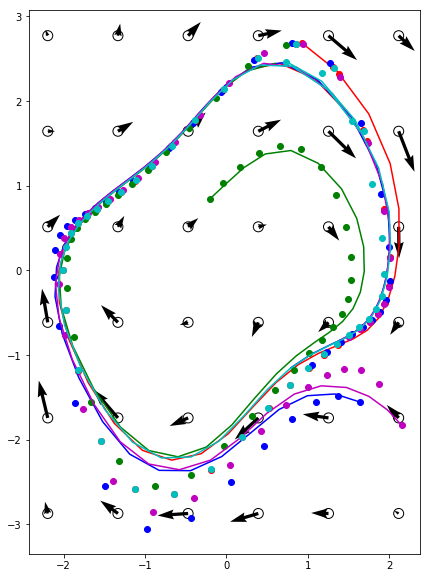

In [15]:
# plotting
mean_U = np.mean([i[0][0][0] for i in chain if i[1]], axis=0)
kreg.U.data = torch.from_numpy(mean_U)
# mean_logsn = np.mean([i[0][0][1] for i in chain if i[1]], axis=0)
# kreg.logsn.data = torch.from_numpy(mean_logsn)
xode = odeint(kreg, x0, t).detach().numpy()
# U = kreg.U.detach().numpy()
U = mean_U
Z = kreg.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

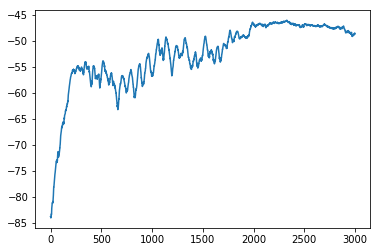

In [16]:
mean_U
plt.plot(logp_array)

In [17]:
sampler.state[kreg.U]

{'data': tensor([[-0.2478,  0.9042],
         [-0.6724,  2.8713],
         [-0.5346,  2.6384],
         [ 0.9164,  0.9447],
         [ 0.6619, -0.0057],
         [-0.1718,  0.4308],
         [-1.3771,  1.0031],
         [-1.8930,  2.2011],
         [-1.3240,  1.2986],
         [ 0.4756,  0.8605],
         [ 1.2101,  0.7255],
         [ 0.2731,  0.9726],
         [-2.3622, -0.1425],
         [-1.4817, -0.6274],
         [-0.6465, -0.2218],
         [ 0.7352,  0.6846],
         [ 1.3638,  1.5097],
         [ 0.9673,  1.0675],
         [-2.2225, -0.6520],
         [-1.7948, -1.7014],
         [-0.5057, -1.1250],
         [ 0.6407,  0.1715],
         [ 1.7938,  0.9446],
         [ 1.8214,  0.4303],
         [-1.3954, -0.0056],
         [-1.9714,  0.2526],
         [-0.8086, -0.7870],
         [ 0.8690, -1.1019],
         [ 2.1441, -2.0893],
         [ 2.2121, -1.8843],
         [-0.3628,  0.2001],
         [-0.9567,  0.9591],
         [-0.6696, -0.9062],
         [ 0.0246, -2.4378],
      